In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.UNet import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = torch.cat([x, bin_channel], dim=1)
print(torch.sum(bin_channel))

tensor(467592.)


In [5]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [6]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')


In [7]:
print(x.shape)
print(y.shape)

torch.Size([961, 4, 172, 79])
torch.Size([961, 3, 172, 79])


In [8]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [9]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [10]:
# Creating model
model = UNet(4, 3, filters=[16,32,64,128,128], kernel_size=7,
                    batch_norm=False, weight_norm=False)
model

UNet(
  (encoders): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), 

In [11]:
# Initializing weights
# initialize(model)

In [12]:
# Initializing optimizer
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [13]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss), output

In [14]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [15]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [16]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [17]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 2706625.5078125
	Train Total MSE = 347.9659067789714
	Train Ux MSE = 329.8886980329241
	Train Uy MSE = 10.218195597330729
	Train p MSE = 7.859013114656721
	Validation Loss = 730800.0437011719
	Validation Total MSE = 224.43774181748756
	Validation Ux MSE = 214.00288665665886
	Validation Uy MSE = 5.906824448529412
	Validation p MSE = 4.528032517350669
Model saved!
Epoch #2
	Train Loss = 1059297.916015625
	Train Total MSE = 111.7679214477539
	Train Ux MSE = 100.83607737223308
	Train Uy MSE = 6.551172733306885
	Train p MSE = 4.380673260915847
	Validation Loss = 245225.4154663086
	Validation Total MSE = 44.55489795513219
	Validation Ux MSE = 36.15211161445169
	Validation Uy MSE = 5.366732300359073
	Validation p MSE = 3.0360529538256897
Model saved!
Epoch #3
	Train Loss = 504767.583984375
	Train Total MSE = 32.65355473472958
	Train Ux MSE = 24.277630578903924
	Train Uy MSE = 4.925350575220017
	Train p MSE = 3.4505738530840193
	Validation Loss = 161572.5467529297
	Valid

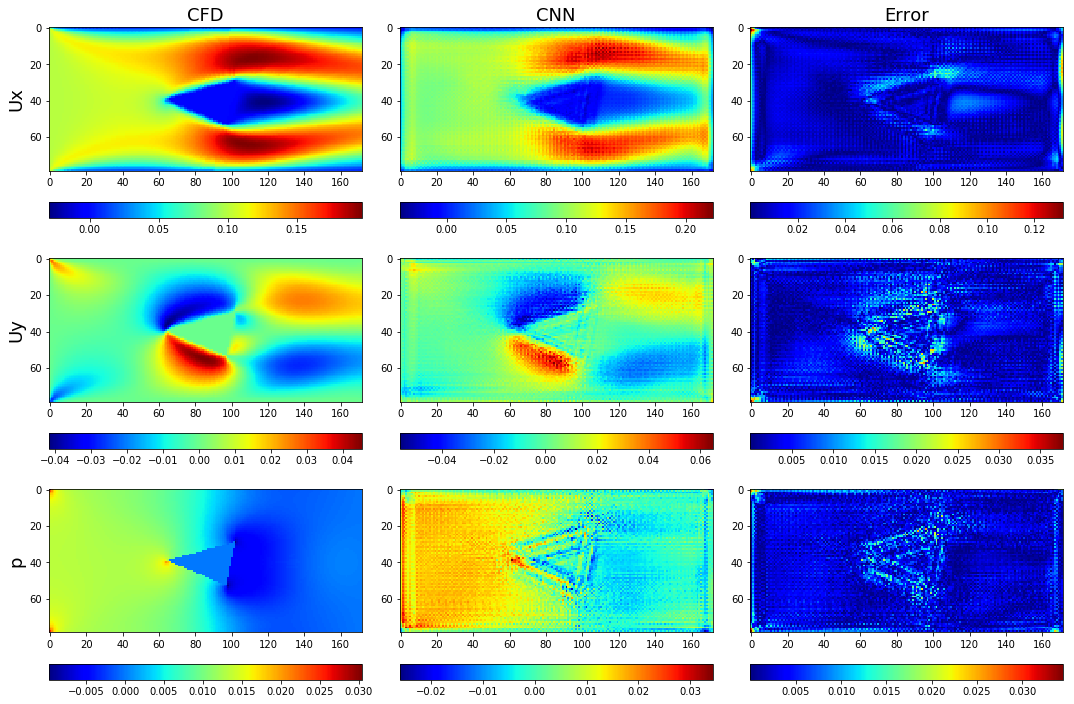

Epoch #11
	Train Loss = 127548.17041015625
	Train Total MSE = 6.5036820230029875
	Train Ux MSE = 4.274134465626308
	Train Uy MSE = 0.779856454758417
	Train p MSE = 1.4496909365767525
	Validation Loss = 36851.00373840332
	Validation Total MSE = 4.731855560751522
	Validation Ux MSE = 3.2731432733238774
	Validation Uy MSE = 0.5581514754922332
	Validation p MSE = 0.9005608179165006
Model saved!
Epoch #12
	Train Loss = 119779.462890625
	Train Total MSE = 5.941666183017549
	Train Ux MSE = 3.8374337695893788
	Train Uy MSE = 0.6872443301337106
	Train p MSE = 1.4169881620577403
	Validation Loss = 33701.57138824463
	Validation Total MSE = 4.292594878318813
	Validation Ux MSE = 2.962941410632282
	Validation Uy MSE = 0.4747769946045529
	Validation p MSE = 0.8548763837781332
Model saved!
Epoch #13
	Train Loss = 115733.32739257812
	Train Total MSE = 5.632383460090274
	Train Ux MSE = 3.589899358295259
	Train Uy MSE = 0.6443213295368921
	Train p MSE = 1.3981628134137107
	Validation Loss = 34714.273361

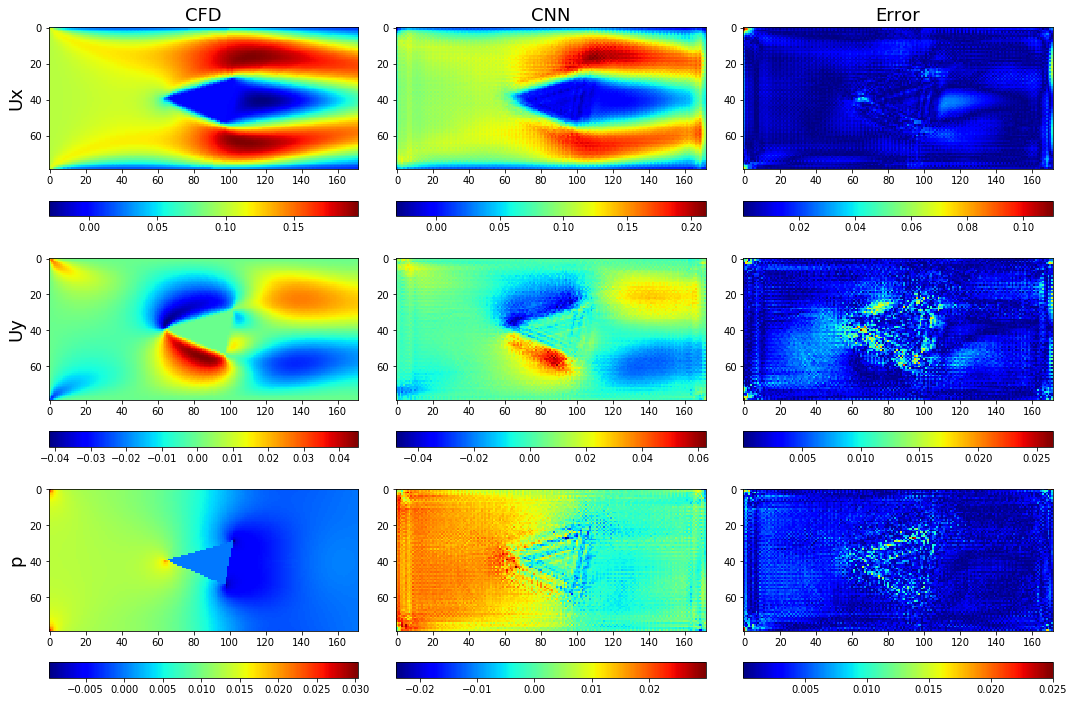

Epoch #21
	Train Loss = 97064.92565917969
	Train Total MSE = 4.012580292565482
	Train Ux MSE = 2.225554420834496
	Train Uy MSE = 0.46239703042166574
	Train p MSE = 1.324628819312368
	Validation Loss = 24694.052658081055
	Validation Total MSE = 2.511694013041196
	Validation Ux MSE = 1.4740946598118976
	Validation Uy MSE = 0.26808496623921974
	Validation p MSE = 0.7695143504848118
Model saved!
Epoch #22
	Train Loss = 94547.43225097656
	Train Total MSE = 3.849145310265677
	Train Ux MSE = 2.1037991501036144
	Train Uy MSE = 0.43790629009405774
	Train p MSE = 1.3074398523285276
	Validation Loss = 24108.78033065796
	Validation Total MSE = 2.3646085790284364
	Validation Ux MSE = 1.3432604082727928
	Validation Uy MSE = 0.24907620684292078
	Validation p MSE = 0.7722719873214675
Model saved!
Epoch #23
	Train Loss = 93830.92248535156
	Train Total MSE = 3.7486222187678018
	Train Ux MSE = 2.0109252362024215
	Train Uy MSE = 0.4194292426109314
	Train p MSE = 1.3182677626609802
	Validation Loss = 24621

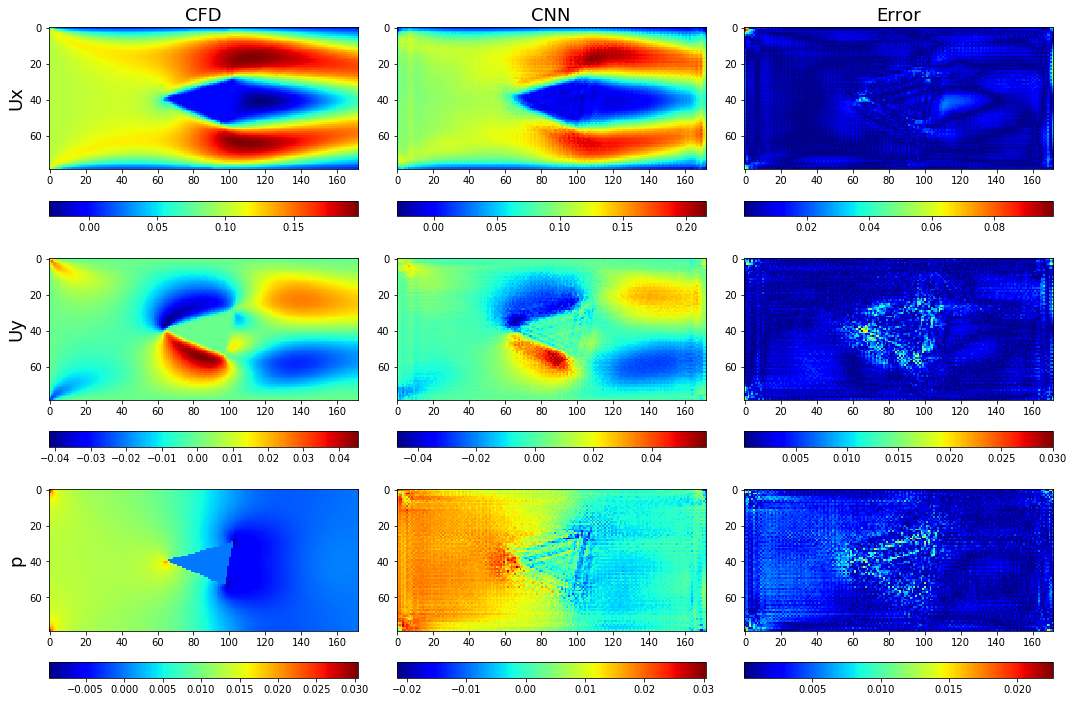

Epoch #31
	Train Loss = 88157.86096191406
	Train Total MSE = 3.406774265425546
	Train Ux MSE = 1.7634567703519548
	Train Uy MSE = 0.376257632459913
	Train p MSE = 1.267059855517887
	Validation Loss = 21682.711889266968
	Validation Total MSE = 1.9553303066834447
	Validation Ux MSE = 1.0211270837222828
	Validation Uy MSE = 0.19651545372801257
	Validation p MSE = 0.7376877033380489
Model saved!
Epoch #32
	Train Loss = 87466.9966430664
	Train Total MSE = 3.2412109829130626
	Train Ux MSE = 1.5953939131328039
	Train Uy MSE = 0.361773723647708
	Train p MSE = 1.2840434043180375
	Validation Loss = 22211.81688308716
	Validation Total MSE = 1.9232687743889831
	Validation Ux MSE = 0.952507863407729
	Validation Uy MSE = 0.21425400648562554
	Validation p MSE = 0.7565068351459339
Epoch #33
	Train Loss = 85787.31384277344
	Train Total MSE = 3.148445645968119
	Train Ux MSE = 1.5291801009859358
	Train Uy MSE = 0.35894088801883517
	Train p MSE = 1.2603247754630589
	Validation Loss = 21395.034545898438
	V

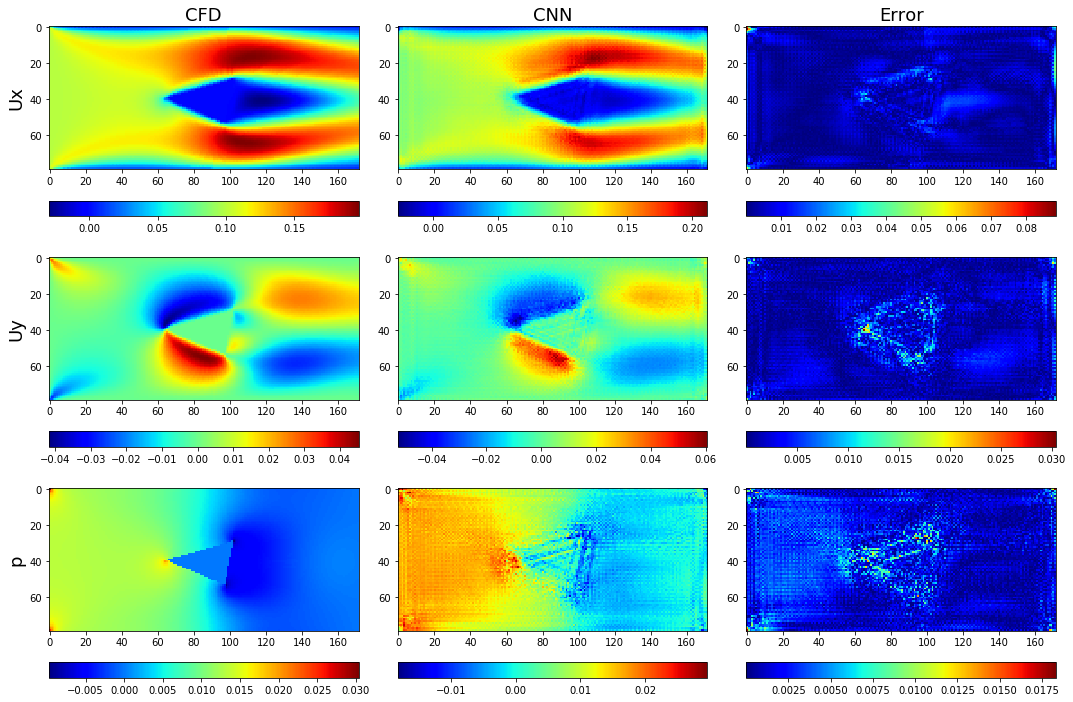

Epoch #41
	Train Loss = 85129.5717163086
	Train Total MSE = 3.16634179013116
	Train Ux MSE = 1.5663727181298392
	Train Uy MSE = 0.3508358775150208
	Train p MSE = 1.2491330944356465
	Validation Loss = 20474.72265815735
	Validation Total MSE = 1.734892058949982
	Validation Ux MSE = 0.8435166051231041
	Validation Uy MSE = 0.1638758613060915
	Validation p MSE = 0.7274995702979474
Epoch #42
	Train Loss = 82903.166015625
	Train Total MSE = 2.986882445358095
	Train Ux MSE = 1.4211789653414773
	Train Uy MSE = 0.32122280980859486
	Train p MSE = 1.2444807152662958
	Validation Loss = 20114.721633911133
	Validation Total MSE = 1.6772341930330006
	Validation Ux MSE = 0.8010746106556955
	Validation Uy MSE = 0.1486099109208295
	Validation p MSE = 0.727549730906437
Model saved!
Epoch #43
	Train Loss = 82834.89172363281
	Train Total MSE = 3.0337026431446983
	Train Ux MSE = 1.475414520218259
	Train Uy MSE = 0.32239528922807603
	Train p MSE = 1.235892876982689
	Validation Loss = 19952.43223953247
	Valida

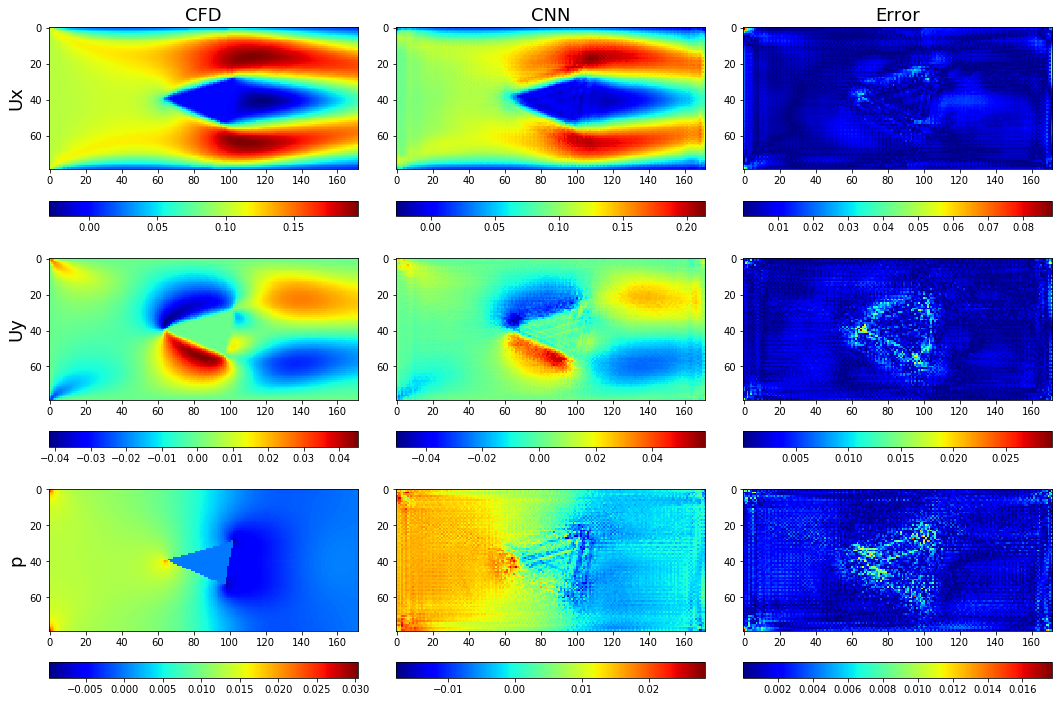

Epoch #51
	Train Loss = 82231.93756103516
	Train Total MSE = 3.123782095454988
	Train Ux MSE = 1.5892398073559715
	Train Uy MSE = 0.3294357756773631
	Train p MSE = 1.2051065869274593
	Validation Loss = 19588.612239837646
	Validation Total MSE = 1.5919943437444297
	Validation Ux MSE = 0.7347158839133372
	Validation Uy MSE = 0.1391164418632184
	Validation p MSE = 0.718161985020324
Model saved!
Epoch #52
	Train Loss = 81861.08099365234
	Train Total MSE = 3.143417457739512
	Train Ux MSE = 1.6218840110869635
	Train Uy MSE = 0.3214012554713658
	Train p MSE = 1.2001320797772634
	Validation Loss = 24585.046548843384
	Validation Total MSE = 2.6395077750757077
	Validation Ux MSE = 1.6483791831455428
	Validation Uy MSE = 0.17314318482438587
	Validation p MSE = 0.8179853891882929
Epoch #53
	Train Loss = 84667.52642822266
	Train Total MSE = 3.3015729756582353
	Train Ux MSE = 1.7357266942660015
	Train Uy MSE = 0.3275903129861468
	Train p MSE = 1.2382560166574659
	Validation Loss = 23128.87558746338


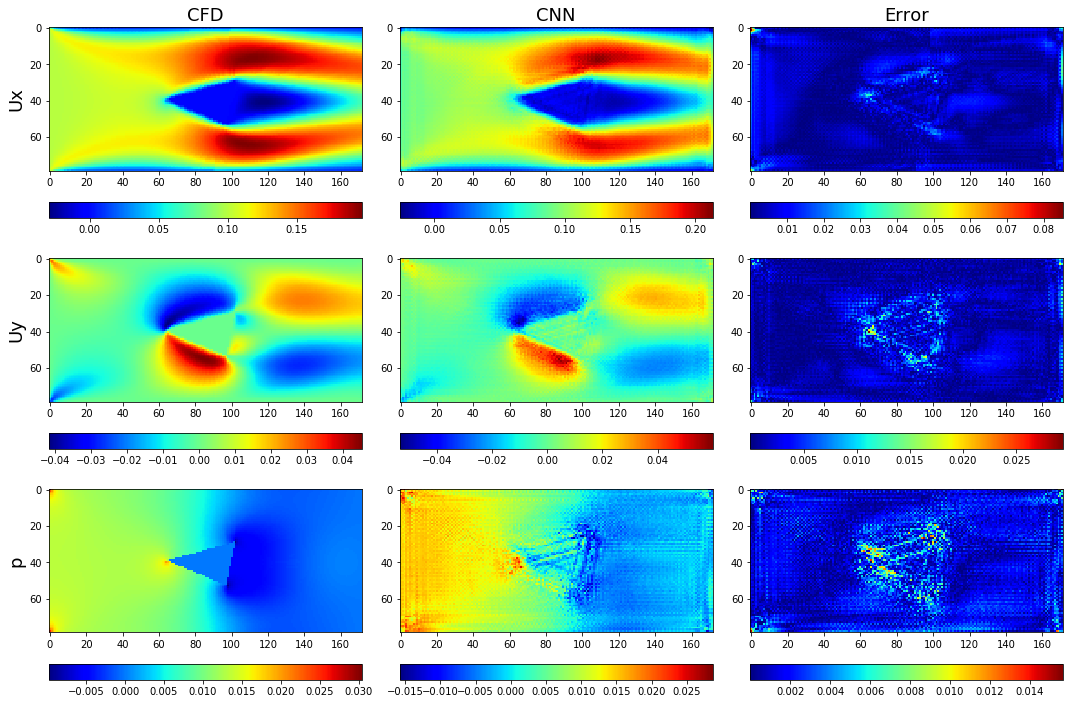

Epoch #61
	Train Loss = 81657.43737792969
	Train Total MSE = 3.1138525832267034
	Train Ux MSE = 1.5939595670927138
	Train Uy MSE = 0.31774955846014474
	Train p MSE = 1.2021434927980106
	Validation Loss = 20322.816299438477
	Validation Total MSE = 1.614109321861531
	Validation Ux MSE = 0.7215546829477726
	Validation Uy MSE = 0.1371823901948632
	Validation p MSE = 0.7553723246684124
Early stopping...


(UNet(
   (encoders): Sequential(
     (0): Sequential(
       (0): Sequential(
         (0): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
     )
     (1): Sequential(
       (0): Sequential(
         (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
     )
     (2): Sequential(
       (0): Sequential(
         (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
       (1): Sequential(
         (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
         (1): ReLU()
       )
     )
     (3): Sequential(
       (0): Sequential(
         (0): Conv2d(64, 128, 

In [18]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_ux_name="Ux MSE",
           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_uy_name="Uy MSE",
           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
           m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           )